<a href="https://colab.research.google.com/github/dolmani38/non-linear-regression/blob/master/Keras%20-%20Regression%20using%20continuous%20and%20categorial%20variables%20with%20embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The purpose of this blog post:

1. To show how to implement (technically) a feature vector with both continuous and categorical features. 
2. To use a Regression head to predict continuous values

We would like to predict the housing prices in 3 different suburbs of Tel Aviv (Mercaz, Old North and Florentine).
Let's assume that a deterministic function $f(a, s, n)$ exist that determines the price of a house where:
* $n$: Number of rooms
* $s$: Size (in square meters)
* $a$: Area (TLV suburb)

For each area $a$ we define a price per square meter $s\_price(a)$ :
* Mercaz: &nbsp;&nbsp;&nbsp; \$500
* Old North: &nbsp;&nbsp;&nbsp; \$350  
* Florentine:  &nbsp;&nbsp;&nbsp; \$230

And an additional price per room $n\_price(a)$:
* Mercaz: &nbsp;&nbsp;&nbsp; \$150,000  
* Old North: &nbsp;&nbsp;&nbsp; \$80,000  
* Florentine: &nbsp;&nbsp;&nbsp; \$50,000

The price of a house in area $a$ with size $s$ and $n$ rooms will be:
$$f(a, s, n) = s * s\_price(a)  + n * n\_price(a)$$

This function is what we will later try to predict with a Regression DNN.

#### Imports and helper functions

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.layers import Input, Embedding, Dense
from keras.models import Model
from keras.callbacks import Callback
import matplotlib.pyplot as plt

# Bayesian Methods for Hackers style sheet
plt.style.use('bmh')

np.random.seed(1234567890)

from keras import backend as K

def r2(y_true, y_pred):
    """
    # custom R2-score metrics for keras backend
    :param y_true: 실측 데이터
    :param y_pred: 모델에 의한 예측 데이테
    :return: R^2 value, 이 값이 높다고 (예:0.99)해서 예측 값이 정확 하다고 할 수 는 없음...
    """
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res / (SS_tot + K.epsilon()))

def soft_acc(y_true, y_pred):
    delta = 600
    return K.mean(K.equal(K.round(y_true/delta), K.round(y_pred/delta)))


class VerboseCallback(keras.callbacks.Callback):
    """
    kerase.model.fit 함수에서, log 출력을 위한 callback
    """
    def __init__(self, epoch):
        self.epoch = epoch
        self.progress("learning:", 0, [])

    def progress(self, text, current=0, log=None):
        g = self.epoch - current
        f = 50 / self.epoch
        c = int(current * f)
        pg = ['=' for i in range(c)] + ['.' for i in range(50 - c)]
        print("\r" + str(text) + "{}/{}[{}]{}".format(current, self.epoch, ''.join(pg), ('' if log is None else str(log).strip())),
              end="", flush=True)
        if self.epoch - current == 0:
            print("")

    def on_epoch_end(self, epoch, logs=None):
        self.progress("learning:", epoch + 1, logs)


class PeriodicLogger(Callback):
    """
    A helper callback class that only prints the losses once in 'display' epochs
    """
    def __init__(self, display=100):
        self.display = display

    def on_train_begin(self, logs={}):      
        self.epochs = 0    

    def on_epoch_end(self, batch, logs={}):    
        self.epochs += 1     
        if self.epochs % self.display == 0:
            print ("Epoch: %d - %s" % (self.epochs, str(logs)))
 
            
periodic_logger_250 = PeriodicLogger(250)

Using TensorFlow backend.


#### Define the mapping and a function that computes the house price for each example

In [2]:
per_meter_mapping = {
    'Mercaz': 500,
    'Old North': 350,
    'Florentine': 230
}

per_room_additional_price = {
    'Mercaz': 15. * 10**4,
    'Old North': 8. * 10**4,
    'Florentine': 5. * 10**4
}

per_type_price = {
    'fullsize': 3,
    'economy': 1.2,
    'convertible': 9,
    'standard': 2.5,
    'premium': 4,
    'intermediate': 2,
    'luxury': 12,
    'compact': 1.5
}

def house_price_func(row):
    """
    house_price_func is the function f(a,s,n).
    
    :param row: dict (contains the keys: ['area', 'size', 'n_rooms'])
    :return: float
    """
    area, size, n_rooms, ctype = row['area'], row['size'], row['n_rooms'], row['ctype']
    return (size * per_meter_mapping[area] - 120) + (n_rooms*n_rooms)/4 * per_room_additional_price[area] * per_type_price[ctype]

### Create toy data

In [3]:
AREAS = ['Mercaz', 'Old North', 'Florentine']
HOUSE_TYPE = ['economy','compact','intermediate','standard','fullsize','premium','luxury','convertible']

def create_samples(n_samples):
    """
    Helper method that creates dataset DataFrames
    
    Note that the np.random.choice call only determines the number of rooms and the size of the house
    (the price, which we calculate later, is deterministic)
    
    :param n_samples: int (number of samples for each area (suburb))
    :return: pd.DataFrame
    """
    samples = []

    for i in range(n_samples):
        samples.append([np.random.choice(AREAS), int(np.random.normal(25, 5)),int(np.random.normal(300, 50)), np.random.choice(range(1, 6)),np.random.choice(HOUSE_TYPE)])
        
    return pd.DataFrame(samples, columns=['area', 'size', 'lamp', 'n_rooms','ctype'])

#### Create the train and validation sets

In [59]:
train = create_samples(n_samples=30000)
val = create_samples(n_samples=3000)

#### Calculate the prices for each set

In [60]:
train['price'] = train.apply(house_price_func, axis=1)
val['price'] = val.apply(house_price_func, axis=1)

#### Here is the structure of the train/val DataFrame

In [61]:
train.head(10)

,area,size,lamp,n_rooms,ctype,price
0,Florentine,21,264,4,luxury,2404710.0
1,Florentine,20,251,3,intermediate,229480.0
2,Old North,34,244,5,intermediate,1011780.0
3,Florentine,13,242,4,luxury,2402870.0
4,Florentine,24,315,1,premium,55400.0
5,Mercaz,24,267,2,standard,386880.0
6,Old North,25,323,4,standard,808630.0
7,Florentine,16,321,2,intermediate,103560.0
8,Florentine,31,343,4,compact,307010.0
9,Old North,16,333,1,convertible,185480.0


#### Define the features and the y vectores
We will separate the continuous and categorical variables

In [62]:
continuous_cols = ['size', 'n_rooms','lamp']
categorical_cols = ['area','ctype']
y_col = ['price']

X_train_continuous = train[continuous_cols]
X_train_categorical = train[categorical_cols]
y_train = train[y_col]

X_val_continuous = val[continuous_cols]
X_val_categorical = val[categorical_cols]
y_val = val[y_col]

In [63]:
# 파생변수 생성

X_train_continuous['size_n_rooms'] = X_train_continuous['size'] * X_train_continuous['n_rooms']
X_train_continuous['size_size'] = X_train_continuous['size'] * X_train_continuous['size']
X_train_continuous['n_rooms_n_rooms'] = X_train_continuous['n_rooms'] * X_train_continuous['n_rooms']

X_val_continuous['size_n_rooms'] = X_val_continuous['size'] * X_val_continuous['n_rooms']
X_val_continuous['size_size'] = X_val_continuous['size'] * X_val_continuous['size']
X_val_continuous['n_rooms_n_rooms'] = X_val_continuous['n_rooms'] * X_val_continuous['n_rooms']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [64]:
ds2 = pd.concat([X_train_continuous,X_train_categorical,y_train], axis=1)
ds2

,size,n_rooms,lamp,size_n_rooms,size_size,n_rooms_n_rooms,area,ctype,price
0,21,4,264,84,441,16,Florentine,luxury,2404710.0
1,20,3,251,60,400,9,Florentine,intermediate,229480.0
2,34,5,244,170,1156,25,Old North,intermediate,1011780.0
3,13,4,242,52,169,16,Florentine,luxury,2402870.0
4,24,1,315,24,576,1,Florentine,premium,55400.0
...,...,...,...,...,...,...,...,...,...
29995,23,5,253,115,529,25,Mercaz,compact,1417630.0
29996,24,3,341,72,576,9,Florentine,fullsize,342900.0
29997,28,2,333,56,784,4,Old North,compact,129680.0
29998,21,2,320,42,441,4,Mercaz,economy,190380.0


#### Normalization

In [65]:
# Normalizing both train and test sets to have 0 mean and std. of 1 using the train set mean and std.
# This will give each feature an equal initial importance and speed up the training time
# zscore norm
train_mean = X_train_continuous.mean(axis=0)
train_std = X_train_continuous.std(axis=0)

X_train_continuous = X_train_continuous - train_mean
X_train_continuous /= train_std

X_val_continuous = X_val_continuous - train_mean
X_val_continuous /= train_std

In [106]:
# min-max norm

train_min = X_train_continuous.min(axis=0)
train_max = X_train_continuous.max(axis=0)

X_train_continuous = X_train_continuous - train_min
X_train_continuous /= train_max

X_val_continuous = X_val_continuous - train_min
X_val_continuous /= train_max

## Build a model using a categorical variable

### First let's define a helper class for the categorical variable

In [66]:
class EmbeddingMapping():
    """
    Helper class for handling categorical variables
    An instance of this class should be defined for each categorical variable we want to use.
    """
    def __init__(self, series):
        # get a list of unique values
        values = series.unique().tolist()
        
        # Set a dictionary mapping from values to integer value
        # In our example this will be {'Mercaz': 1, 'Old North': 2, 'Florentine': 3}
        self.embedding_dict = {value: int_value+1 for int_value, value in enumerate(values)}
        
        # The num_values will be used as the input_dim when defining the embedding layer. 
        # It will also be returned for unseen values 
        self.num_values = len(values) + 1

    def get_mapping(self, value):
        # If the value was seen in the training set, return its integer mapping
        if value in self.embedding_dict:
            return self.embedding_dict[value]
        
        # Else, return the same integer for unseen values
        else:
            return self.num_values

### Create an embedding column for the train/validation sets

In [67]:
area_mapping = EmbeddingMapping(X_train_categorical['area'])
type_mapping = EmbeddingMapping(X_train_categorical['ctype'])

X_train_categorical = X_train_categorical.assign(area_mapping=X_train_categorical['area'].apply(area_mapping.get_mapping))
X_train_categorical = X_train_categorical.assign(type_mapping=X_train_categorical['ctype'].apply(type_mapping.get_mapping))
X_val_categorical = X_val_categorical.assign(area_mapping=X_val_categorical['area'].apply(area_mapping.get_mapping))
X_val_categorical = X_val_categorical.assign(type_mapping=X_val_categorical['ctype'].apply(type_mapping.get_mapping))

#### A corresponding 'area_mapping' column was added to the train/validation sets

In [68]:
X_train_continuous_org = X_train_continuous
X_train_categorical_org = X_train_categorical
X_val_continuous_org = X_val_continuous
X_val_categorical_org = X_val_categorical

# 학습 대상 변수만 선택
X_train_continuous = X_train_continuous_org[['size','n_rooms','n_rooms_n_rooms']]
X_train_categorical = X_train_categorical_org
X_val_continuous  = X_val_continuous_org[['size','n_rooms','n_rooms_n_rooms']]
X_val_categorical = X_val_categorical_org


In [69]:
ds2 = pd.concat([X_train_continuous,X_train_categorical,y_train], axis=1)
ds2

,size,n_rooms,n_rooms_n_rooms,area,ctype,area_mapping,type_mapping,price
0,-0.701979,0.709465,0.581026,Florentine,luxury,1,1,2404710.0
1,-0.901512,0.003108,-0.228815,Florentine,intermediate,1,2,229480.0
2,1.891956,1.415822,1.622251,Old North,intermediate,2,2,1011780.0
3,-2.298246,0.709465,0.581026,Florentine,luxury,1,1,2402870.0
4,-0.103378,-1.409606,-1.154348,Florentine,premium,1,3,55400.0
...,...,...,...,...,...,...,...,...
29995,-0.302912,1.415822,1.622251,Mercaz,compact,3,5,1417630.0
29996,-0.103378,0.003108,-0.228815,Florentine,fullsize,1,7,342900.0
29997,0.694756,-0.703249,-0.807273,Old North,compact,2,5,129680.0
29998,-0.701979,-0.703249,-0.807273,Mercaz,economy,3,8,190380.0


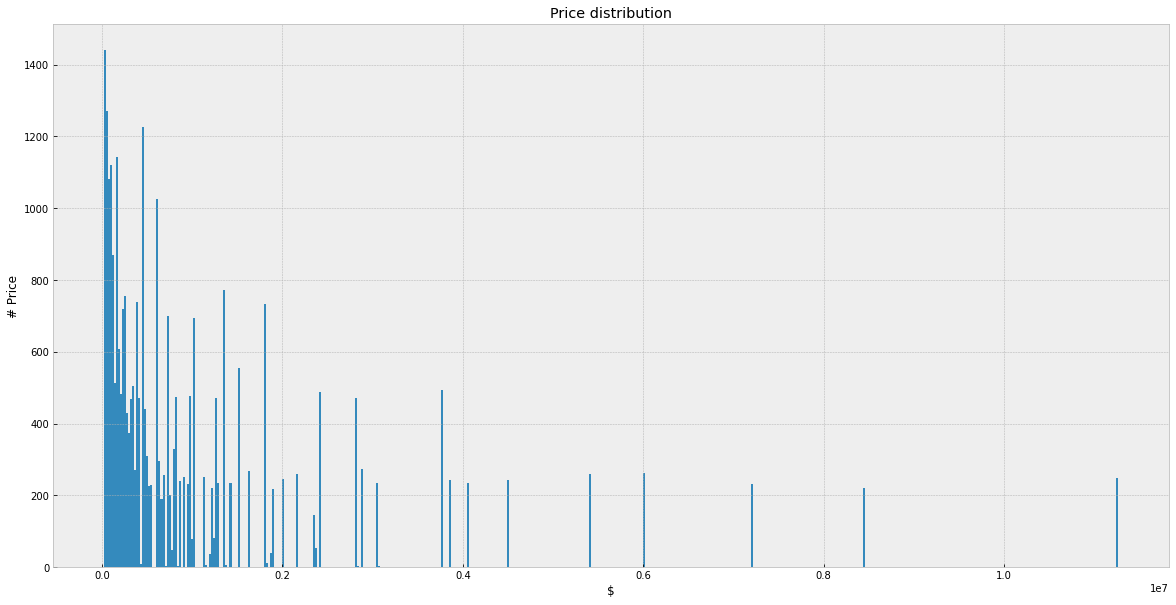

In [70]:
# Here is the histogram of the differences
plt.figure(figsize=(20,10))
plt.hist(y_train['price'], bins=500)
plt.xlabel("$")
plt.ylabel("# Price")
_ = plt.title("Price distribution")

### Define the input layers

In [44]:
# Define the embedding input
cate_input = Input(shape=(2,), dtype='int32') 

# Decide to what vector size we want to map our 'area' variable. 
# I'll use 1 here because we only have three areas
embeddings_output = 24*3


# Let’s define the embedding layer and flatten it
cate_embedings = Embedding(output_dim=embeddings_output, input_dim=X_train_categorical.shape[0])(cate_input)
cate_embedings = keras.layers.Reshape((embeddings_output*2,))(cate_embedings)
print(cate_embedings)
# Define the continuous variables input (just like before)
continuous_input = Input(shape=(X_train_continuous.shape[1], ))

# Concatenate continuous and embeddings inputs
all_input = keras.layers.concatenate([continuous_input, cate_embedings])

Tensor("reshape_1/Reshape:0", shape=(None, 144), dtype=float32)


In [45]:
all_input.shape[1]

147

### To merge them together we will use [Keras Functional API](https://keras.io/getting-started/functional-api-guide/)
Will define a simple model with 2 hidden layers, with 25 neurons each.

In [124]:
# Define the model
dense1 = Dense(all_input.shape[1]*3, activation='relu')(all_input)
dense2 = Dense(int(all_input.shape[1]/6), activation='relu')(dense1)
predictions = Dense(1)(dense2)

# Note using the input object 'area_input' not 'area_embeddings'
model = Model(inputs=[continuous_input, cate_input], outputs=predictions)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=.8, beta_1=0.9, beta_2=0.999, decay=1e-03, amsgrad=True),metrics=[soft_acc,r2])
model.summary()

Model: "model_32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 2)            0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 2, 72)        216000      input_21[0][0]                   
__________________________________________________________________________________________________
input_22 (InputLayer)           (None, 3)            0                                            
__________________________________________________________________________________________________
reshape_11 (Reshape)            (None, 144)          0           embedding_11[0][0]               
___________________________________________________________________________________________

#### Lets train the model

In [126]:
epochs = 10000

# Note continuous and categorical columns are inserted in the same order as defined in all_inputs
history = model.fit([X_train_continuous, X_train_categorical[['area_mapping','type_mapping']].to_numpy()], y_train, 
          epochs=epochs, batch_size=128, 
          callbacks=[periodic_logger_250], verbose=0,
          validation_data=([X_val_continuous, X_val_categorical[['area_mapping','type_mapping']].to_numpy()], y_val))

Epoch: 250 - {'val_loss': 122790.10822916667, 'val_soft_acc': 0.732481062412262, 'val_r2': 0.9999999403953552, 'loss': 40210.498625, 'soft_acc': 0.80045575, 'r2': 1.0}
Epoch: 500 - {'val_loss': 105989.38375, 'val_soft_acc': 0.7585227489471436, 'val_r2': 1.0, 'loss': 31697.423723958334, 'soft_acc': 0.81970793, 'r2': 1.0}
Epoch: 750 - {'val_loss': 98861.41239583334, 'val_soft_acc': 0.7786458134651184, 'val_r2': 1.0, 'loss': 27400.56759375, 'soft_acc': 0.83212423, 'r2': 1.0}
Epoch: 1000 - {'val_loss': 91456.79328125, 'val_soft_acc': 0.7608901858329773, 'val_r2': 1.0, 'loss': 24610.0685078125, 'soft_acc': 0.83696055, 'r2': 1.0}
Epoch: 1250 - {'val_loss': 86927.99989583333, 'val_soft_acc': 0.7990056872367859, 'val_r2': 1.0, 'loss': 22729.705091145832, 'soft_acc': 0.8475168, 'r2': 1.0}
Epoch: 1500 - {'val_loss': 82834.66333333333, 'val_soft_acc': 0.7937973141670227, 'val_r2': 1.0, 'loss': 21413.015442708333, 'soft_acc': 0.84714466, 'r2': 1.0}
Epoch: 1750 - {'val_loss': 80895.68572916667, 'va

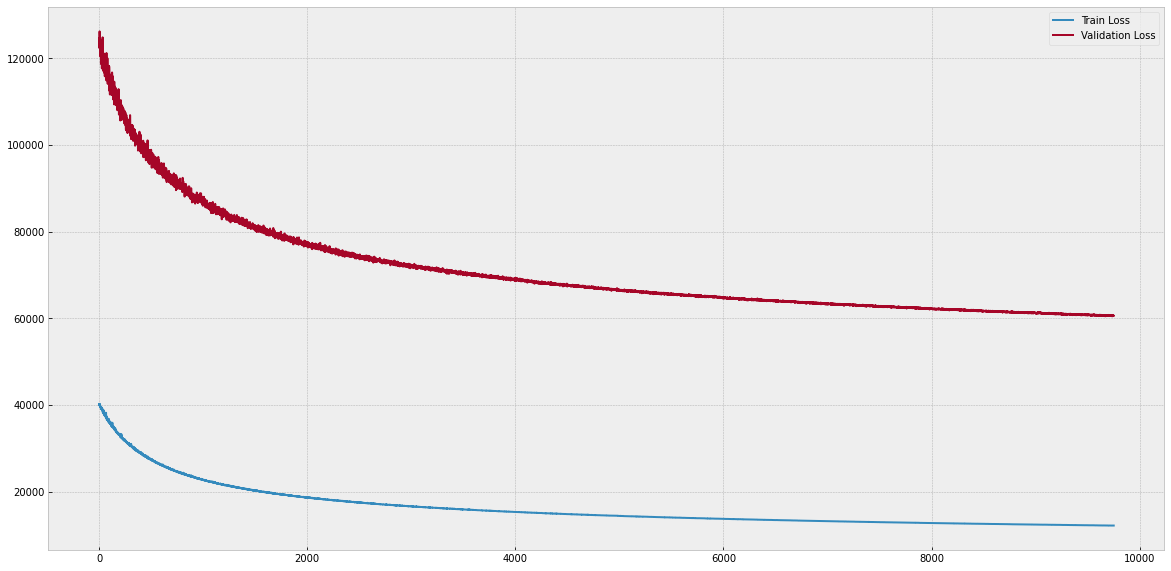

In [127]:
# Plot the train/validation loss values
plt.figure(figsize=(20,10))
_loss = history.history['loss'][250:]
_val_loss = history.history['val_loss'][250:]

train_loss_plot, = plt.plot(range(1, len(_loss)+1), _loss, label='Train Loss')
val_loss_plot, = plt.plot(range(1, len(_val_loss)+1), _val_loss, label='Validation Loss')

_ = plt.legend(handles=[train_loss_plot, val_loss_plot])

After ~500 epochs the validation_loss is very low. This would have been a very good result if this was a "real world problem", particularly because we are using a quadratic loss function (Mean Square Error) when trying to predict a large value:

## How good are the model's predictions?

This is the average value we are trying to predict: 1068854
         price          pred         diff     abs_diff     %diff  abs_%diff
202  1806880.0  1.808667e+06  1787.125000  1787.125000  0.098907   0.098907
63    457380.0  4.588910e+05  1511.031250  1511.031250  0.330367   0.330367
21   1263180.0  1.264591e+06  1410.625000  1410.625000  0.111673   0.111673
162   245130.0  2.464071e+05  1277.109375  1277.109375  0.520993   0.520993
106   972480.0  9.736444e+05  1164.437500  1164.437500  0.119739   0.119739
The mean is very close to 0 (43.38) with std. 242.71.


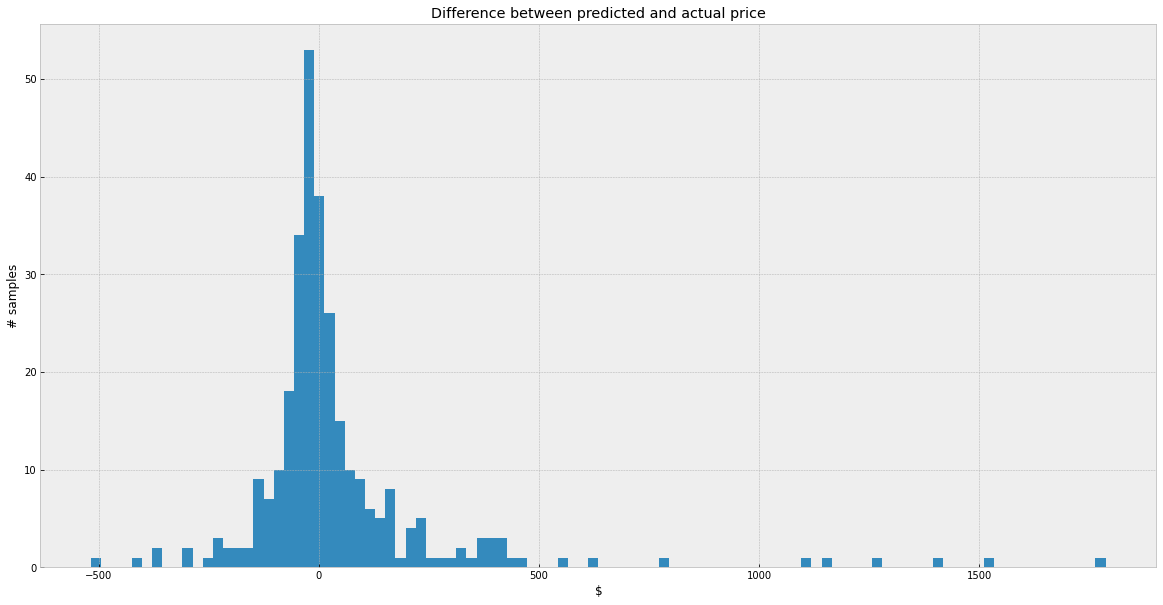

In [128]:
print ("This is the average value we are trying to predict: %d" % y_val.mean().iloc[0])

df = y_val.copy()

# Add a column for the model's predicted values
df['pred'] = model.predict([X_val_continuous, X_val_categorical[['area_mapping','type_mapping']].to_numpy()])

# Calculate the difference between the predicted and the actual price
df['diff'] = df['pred'] - df['price']

# Calculate the absolute difference between the predicted and the actual price
df['abs_diff'] = np.abs(df['diff'])

# Calculate the percentage of the difference from the actual price
df['%diff'] = 100 * (df['diff'] / df['price'])

# Calculate the absolute percentage difference from the actual price
df['abs_%diff'] = np.abs(df['%diff'])

# Sort by the 'abs_diff' field and show the 5 largest mistakes in absolute values
print(df.sort_values("abs_diff", ascending=False).head(5))
# Calculate the mean and std. of the diff field
diff_mean, diff_std = df['diff'].mean(), df['diff'].std()
print("The mean is very close to 0 ({mean}) with std. {std}.".format(mean=round(diff_mean, 2), std=round(diff_std, 2)))

# Here is the histogram of the differences
plt.figure(figsize=(20,10))
plt.hist(df['diff'], bins=100)
plt.xlabel("$")
plt.ylabel("# samples")
_ = plt.title("Difference between predicted and actual price")

        price           pred         diff     abs_diff     %diff  abs_%diff
159   32240.0   32645.308594   405.308594   405.308594  1.257161   1.257161
158   19020.0   19234.179688   214.179688   214.179688  1.126076   1.126076
233  152870.0  153976.421875  1106.421875  1106.421875  0.723767   0.723767
185   61880.0   61477.425781  -402.574219   402.574219 -0.650572   0.650572
59    64130.0   64523.863281   393.863281   393.863281  0.614164   0.614164


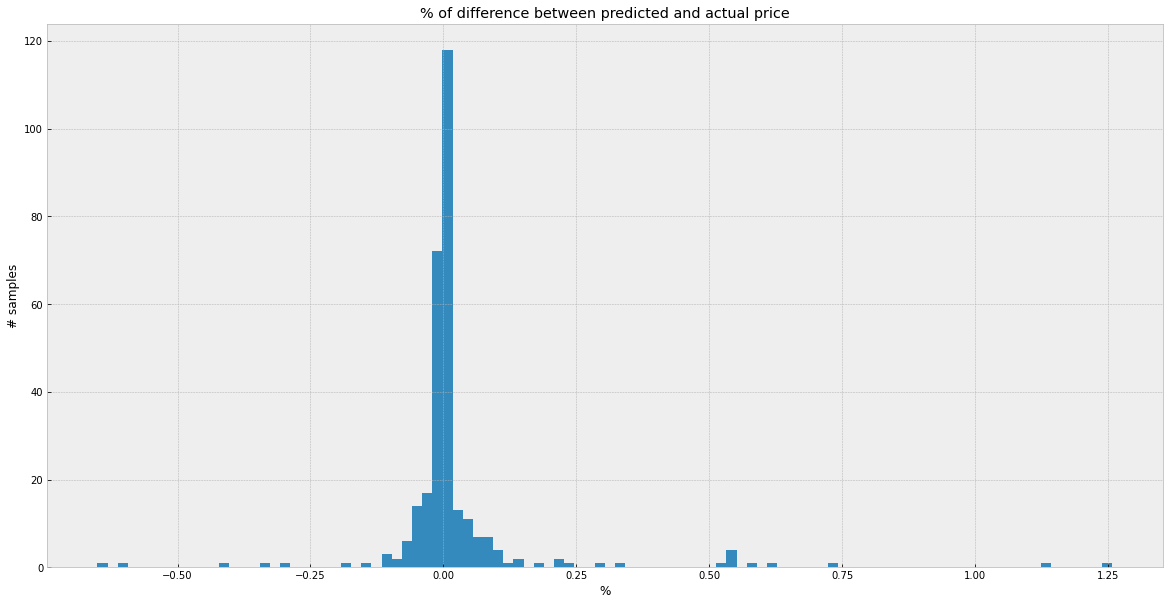

In [129]:
# Sort by the '%diff' field and show the 5 largest proportional mistakes
print(df.sort_values("abs_%diff", ascending=False).head(5))

# Also, plot the histogram
plt.figure(figsize=(20,10))
plt.hist(df['%diff'], bins=100)
plt.xlabel("%")
plt.ylabel("# samples")
_ = plt.title("% of difference between predicted and actual price")

In [133]:
!pip install lime

     |████████████████████████████████| 276kB 7.3MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283845 sha256=c2a1d44910dc58e441f98de355b84372ef8ba4d239af5ee18e3a3d38610ad27a
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [130]:
train_ds = pd.concat([X_train_continuous,X_train_categorical[['area_mapping','type_mapping']]], axis=1)
val_ds = pd.concat([X_val_continuous,X_val_categorical[['area_mapping','type_mapping']]], axis=1)


In [131]:
val_ds

,size,n_rooms,n_rooms_n_rooms,area_mapping,type_mapping
0,-0.083513,-0.693735,-0.801680,2,7
1,1.319502,0.009137,-0.224572,1,7
2,0.718210,0.009137,-0.224572,3,6
3,0.317349,-1.396607,-1.147944,2,6
4,1.720363,-1.396607,-1.147944,3,1
...,...,...,...,...,...
295,-1.085666,0.712009,0.583379,1,6
296,-0.885235,-0.693735,-0.801680,3,3
297,1.920794,-1.396607,-1.147944,3,2
298,-0.283943,0.009137,-0.224572,2,8


In [134]:
# XAI를 위한 lime  정의
from lime import lime_tabular, lime_text
exp = lime_tabular.LimeTabularExplainer(
    train_ds.to_numpy(),
    training_labels=y_train.to_numpy(),
    feature_names=train_ds.columns,
    class_names= y_train.columns,
    mode="regression"
)


In [135]:
# 변수의 영향력 분석
# 소팅을 위한 초기화 
exp_ana = {}
for k in train_ds.columns:
  exp_ana[k] = 0

# predict 함수 재정의 - lime에서 사용 가능하도록...
continue_dim = X_train_continuous.shape[1]
input_dim = train_ds.shape[1]
def predict(data):
    return model.predict([data[:,0:continue_dim],data[:,continue_dim:input_dim]])

# validation set의 변수 영향력 분석...
for i in range(40): #range(val_ds.shape[0]):
    p = exp.explain_instance(np.asarray(val_ds.iloc[i]),predict,num_features=val_ds.shape[1])
    for t in p.as_map()[0]:
      exp_ana[train_ds.columns[t[0]]] += np.abs(t[1])

import operator

sorted_x = sorted(exp_ana.items(), key=operator.itemgetter(1))

effect_result_table = pd.DataFrame(sorted_x,columns=['Feature', 'Effect'] )


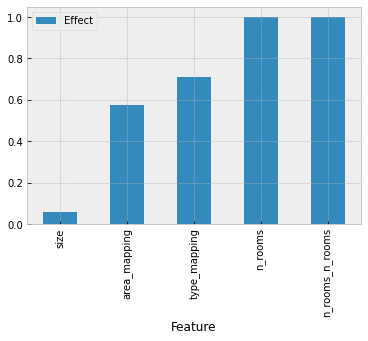

In [136]:
effect_result_table['Effect'] = effect_result_table['Effect']/max(effect_result_table['Effect'])
effect_result_table.plot(x='Feature',y='Effect',kind='bar')

In [80]:
# 학습 대상 변수 전체 선택
X_train_continuous = X_train_continuous_org
X_train_categorical = X_train_categorical_org
X_val_continuous  = X_val_continuous_org
X_val_categorical = X_val_categorical_org

# Define the embedding input
cate_input = Input(shape=(2,), dtype='int32') 

# Decide to what vector size we want to map our 'area' variable. 
# I'll use 1 here because we only have three areas
embeddings_output = 24


# Let’s define the embedding layer and flatten it
cate_embedings = Embedding(output_dim=embeddings_output, input_dim=X_train_categorical.shape[0])(cate_input)
print(cate_embedings)
cate_embedings = keras.layers.Reshape((embeddings_output*2,))(cate_embedings)

# Define the continuous variables input (just like before)
continuous_input = Input(shape=(X_train_continuous.shape[1], ))

# Concatenate continuous and embeddings inputs
all_input = keras.layers.concatenate([continuous_input, cate_embedings])

# Define the model
dense1 = Dense(all_input.shape[1]*2, activation='relu')(all_input)
dense2 = Dense(all_input.shape[1], activation='relu')(dense1)
predictions = Dense(1)(dense2)
# Note using the input object 'area_input' not 'area_embeddings'
model = Model(inputs=[continuous_input, cate_input], outputs=predictions)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=.8, beta_1=0.9, beta_2=0.999, decay=1e-03, amsgrad=True),metrics=[soft_acc,r2])
model.summary()


Tensor("embedding_9/embedding_lookup/Identity_1:0", shape=(None, 2, 24), dtype=float32)
Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 2)            0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 2, 24)        72000       input_17[0][0]                   
__________________________________________________________________________________________________
input_18 (InputLayer)           (None, 6)            0                                            
__________________________________________________________________________________________________
reshape_9 (Reshape)             (None, 48)           0           embedding_9[0][0]                
___

In [81]:
epochs = 2000

# Note continuous and categorical columns are inserted in the same order as defined in all_inputs
history = model.fit([X_train_continuous, X_train_categorical[['area_mapping','type_mapping']].to_numpy()], y_train, 
          epochs=epochs, batch_size=128, 
          callbacks=[periodic_logger_250], verbose=0,
          validation_data=([X_val_continuous, X_val_categorical[['area_mapping','type_mapping']].to_numpy()], y_val))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch: 250 - {'val_loss': 26187096.48, 'val_soft_acc': 0.11292613297700882, 'val_r2': 0.9999895691871643, 'loss': 13828588.08, 'soft_acc': 0.11170015, 'r2': 0.9999946}
Epoch: 500 - {'val_loss': 22510108.85333333, 'val_soft_acc': 0.09801136702299118, 'val_r2': 0.9999909400939941, 'loss': 11211363.768, 'soft_acc': 0.13723029, 'r2': 0.9999954}
Epoch: 750 - {'val_loss': 19757523.253333334, 'val_soft_acc': 0.11339962482452393, 'val_r2': 0.9999918937683105, 'loss': 9950210.092, 'soft_acc': 0.14718191, 'r2': 0.99999595}
Epoch: 1000 - {'val_loss': 15531187.12, 'val_soft_acc': 0.12926135957241058, 'val_r2': 0.9999935626983643, 'loss': 7721098.729333334, 'soft_acc': 0.13337053, 'r2': 0.99999714}
Epoch: 1250 - {'val_loss': 13102644.48, 'val_soft_acc': 0.12665720283985138, 'val_r2': 0.9999945759773254, 'loss': 6179716.042666666, 'soft_acc': 0.14225261, 'r2': 0.9999977}
Epoch: 1500 - {'val_loss': 12233199.84, 'val_soft_acc': 0.12878787517547607, 'val_r2': 0.9999948143959045, 'loss': 5200991.1133333

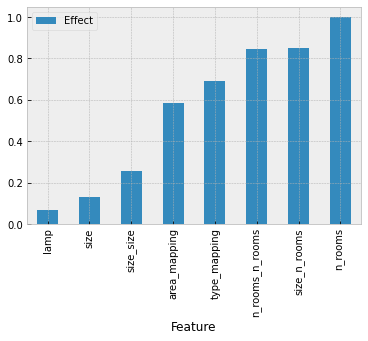

In [82]:
train_ds = pd.concat([X_train_continuous,X_train_categorical[['area_mapping','type_mapping']]], axis=1)
val_ds = pd.concat([X_val_continuous,X_val_categorical[['area_mapping','type_mapping']]], axis=1)
# XAI를 위한 lime  정의
from lime import lime_tabular, lime_text
exp = lime_tabular.LimeTabularExplainer(
    train_ds.to_numpy(),
    training_labels=y_train.to_numpy(),
    feature_names=train_ds.columns,
    class_names= y_train.columns,
    mode="regression"
)
# 변수의 영향력 분석
# 소팅을 위한 초기화 
exp_ana = {}
for k in train_ds.columns:
  exp_ana[k] = 0

# predict 함수 재정의 - lime에서 사용 가능하도록...
continue_dim = X_train_continuous.shape[1]
input_dim = train_ds.shape[1]
def predict(data):
    return model.predict([data[:,0:continue_dim],data[:,continue_dim:input_dim]])

# validation set의 변수 영향력 분석...
for i in range(40): #range(val_ds.shape[0]):
    p = exp.explain_instance(np.asarray(val_ds.iloc[i]),predict,num_features=val_ds.shape[1])
    for t in p.as_map()[0]:
      exp_ana[train_ds.columns[t[0]]] += np.abs(t[1])

import operator

sorted_x = sorted(exp_ana.items(), key=operator.itemgetter(1))

effect_result_table = pd.DataFrame(sorted_x,columns=['Feature', 'Effect'] )

effect_result_table['Effect'] = effect_result_table['Effect']/max(effect_result_table['Effect'])
effect_result_table.plot(x='Feature',y='Effect',kind='bar')


In [92]:
# 끝에 두개... 교차 삭제 테스트
X_train_continuous = X_train_continuous_org[['n_rooms_n_rooms','size_n_rooms','n_rooms']]
X_val_continuous  = X_val_continuous_org[['n_rooms_n_rooms','size_n_rooms','n_rooms']]

print(X_train_continuous)
# Define the embedding input
cate_input = Input(shape=(2,), dtype='int32') 

# Decide to what vector size we want to map our 'area' variable. 
# I'll use 1 here because we only have three areas
embeddings_output = 24


# Let’s define the embedding layer and flatten it
cate_embedings = Embedding(output_dim=embeddings_output, input_dim=X_train_categorical.shape[0])(cate_input)
print(cate_embedings)
cate_embedings = keras.layers.Reshape((embeddings_output*2,))(cate_embedings)

# Define the continuous variables input (just like before)
continuous_input = Input(shape=(X_train_continuous.shape[1], ))

# Concatenate continuous and embeddings inputs
all_input = keras.layers.concatenate([continuous_input, cate_embedings])

# Define the model
dense1 = Dense(all_input.shape[1]*2, activation='relu')(all_input)
dense2 = Dense(all_input.shape[1], activation='relu')(dense1)
predictions = Dense(1)(dense2)
# Note using the input object 'area_input' not 'area_embeddings'
model = Model(inputs=[continuous_input, cate_input], outputs=predictions)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=.8, beta_1=0.9, beta_2=0.999, decay=1e-03, amsgrad=True),metrics=[soft_acc,r2])
model.summary()

epochs = 500
# Note continuous and categorical columns are inserted in the same order as defined in all_inputs
history = model.fit([X_train_continuous, X_train_categorical[['area_mapping','type_mapping']].to_numpy()], y_train, 
          epochs=epochs, batch_size=128, 
          callbacks=[periodic_logger_250], verbose=0,
          validation_data=([X_val_continuous, X_val_categorical[['area_mapping','type_mapping']].to_numpy()], y_val))

      n_rooms_n_rooms  size_n_rooms   n_rooms
0           -0.781991     -0.519037 -0.676610
1           -0.197834     -0.388512  0.034115
2            1.671468      1.517154  1.455564
3           -1.132485     -1.197768 -1.387335
4            1.671468      2.169779  1.455564
...               ...           ...       ...
2995         0.619985      0.107483  0.744840
2996        -0.781991     -0.727877 -0.676610
2997        -0.781991     -1.145558 -0.676610
2998        -1.132485     -1.223873 -1.387335
2999         1.671468      1.125579  1.455564

[3000 rows x 3 columns]
Tensor("embedding_16/embedding_lookup/Identity_1:0", shape=(None, 2, 24), dtype=float32)
Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           (None, 2)            0                                            
___________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch: 250 - {'val_loss': 4074839.53, 'val_soft_acc': 0.14985795319080353, 'val_r2': 0.9999987483024597, 'loss': 3820444.816, 'soft_acc': 0.19652158, 'r2': 0.9999983}
Epoch: 500 - {'val_loss': 3133140.8433333333, 'val_soft_acc': 0.2296401411294937, 'val_r2': 0.9999990463256836, 'loss': 2733866.970333333, 'soft_acc': 0.24590774, 'r2': 0.99999905}


In [93]:
# 끝에 두개... 교차 삭제 테스트
X_train_continuous = X_train_continuous_org[['size','n_rooms_n_rooms','n_rooms']]
X_val_continuous  = X_val_continuous_org[['size','n_rooms_n_rooms','n_rooms']]

print(X_train_continuous)
# Define the embedding input
cate_input = Input(shape=(2,), dtype='int32') 

# Decide to what vector size we want to map our 'area' variable. 
# I'll use 1 here because we only have three areas
embeddings_output = 24


# Let’s define the embedding layer and flatten it
cate_embedings = Embedding(output_dim=embeddings_output, input_dim=X_train_categorical.shape[0])(cate_input)
print(cate_embedings)
cate_embedings = keras.layers.Reshape((embeddings_output*2,))(cate_embedings)

# Define the continuous variables input (just like before)
continuous_input = Input(shape=(X_train_continuous.shape[1], ))

# Concatenate continuous and embeddings inputs
all_input = keras.layers.concatenate([continuous_input, cate_embedings])

# Define the model
dense1 = Dense(all_input.shape[1]*2, activation='relu')(all_input)
dense2 = Dense(all_input.shape[1], activation='relu')(dense1)
predictions = Dense(1)(dense2)
# Note using the input object 'area_input' not 'area_embeddings'
model = Model(inputs=[continuous_input, cate_input], outputs=predictions)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=.8, beta_1=0.9, beta_2=0.999, decay=1e-03, amsgrad=True),metrics=[soft_acc,r2])
model.summary()

epochs = 500
# Note continuous and categorical columns are inserted in the same order as defined in all_inputs
history = model.fit([X_train_continuous, X_train_categorical[['area_mapping','type_mapping']].to_numpy()], y_train, 
          epochs=epochs, batch_size=128, 
          callbacks=[periodic_logger_250], verbose=0,
          validation_data=([X_val_continuous, X_val_categorical[['area_mapping','type_mapping']].to_numpy()], y_val))


          size  n_rooms_n_rooms   n_rooms
0     0.349450        -0.781991 -0.676610
1    -1.069980        -0.197834  0.034115
2     0.349450         1.671468  1.455564
3     0.349450        -1.132485 -1.387335
4     1.363329         1.671468  1.455564
...        ...              ...       ...
2995 -1.069980         0.619985  0.744840
2996 -0.461653        -0.781991 -0.676610
2997 -2.083860        -0.781991 -0.676610
2998  0.146675        -1.132485 -1.387335
2999 -0.258877         1.671468  1.455564

[3000 rows x 3 columns]
Tensor("embedding_17/embedding_lookup/Identity_1:0", shape=(None, 2, 24), dtype=float32)
Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           (None, 2)            0                                            
___________________________________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch: 250 - {'val_loss': 1665137.19, 'val_soft_acc': 0.3217329680919647, 'val_r2': 0.9999992847442627, 'loss': 1822144.4683333333, 'soft_acc': 0.32817152, 'r2': 0.9999993}
Epoch: 500 - {'val_loss': 1296557.59, 'val_soft_acc': 0.46117424964904785, 'val_r2': 0.999999463558197, 'loss': 1360914.7863333332, 'soft_acc': 0.48842075, 'r2': 0.9999996}


In [1]:
train_ds = pd.concat([X_train_continuous,X_train_categorical[['area_mapping','type_mapping']]], axis=1)
val_ds = pd.concat([X_val_continuous,X_val_categorical[['area_mapping','type_mapping']]], axis=1)
# XAI를 위한 lime  정의
from lime import lime_tabular, lime_text
exp = lime_tabular.LimeTabularExplainer(
    train_ds.to_numpy(),
    training_labels=y_train.to_numpy(),
    feature_names=train_ds.columns,
    class_names= y_train.columns,
    mode="regression"
)
# 변수의 영향력 분석
# 소팅을 위한 초기화 
exp_ana = {}
for k in train_ds.columns:
  exp_ana[k] = 0

# predict 함수 재정의 - lime에서 사용 가능하도록...
continue_dim = X_train_continuous.shape[1]
input_dim = train_ds.shape[1]
def predict(data):
    return model.predict([data[:,0:continue_dim],data[:,continue_dim:input_dim]])

# validation set의 변수 영향력 분석...
for i in range(40): #range(val_ds.shape[0]):
    p = exp.explain_instance(np.asarray(val_ds.iloc[i]),predict,num_features=val_ds.shape[1])
    for t in p.as_map()[0]:
      exp_ana[train_ds.columns[t[0]]] += np.abs(t[1])

import operator

sorted_x = sorted(exp_ana.items(), key=operator.itemgetter(1))

effect_result_table = pd.DataFrame(sorted_x,columns=['Feature', 'Effect'] )

effect_result_table['Effect'] = effect_result_table['Effect']/max(effect_result_table['Effect'])
effect_result_table.plot(x='Feature',y='Effect',kind='bar')

NameError: ignored

In [71]:
# price를 category로 만들어서 ... classification을 적용해 본다~
range_count = 500
max = y_train['price'].max()
min = y_train['price'].min()
wdw = (max-min) / (range_count-1)
r = []
for idx in range(range_count+1):
    r.append(min + (idx * wdw) - wdw)
y_train['cate_price'] = pd.cut(y_train['price'], bins=r).cat.codes
y_val['cate_price'] = pd.cut(y_val['price'], bins=r).cat.codes

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


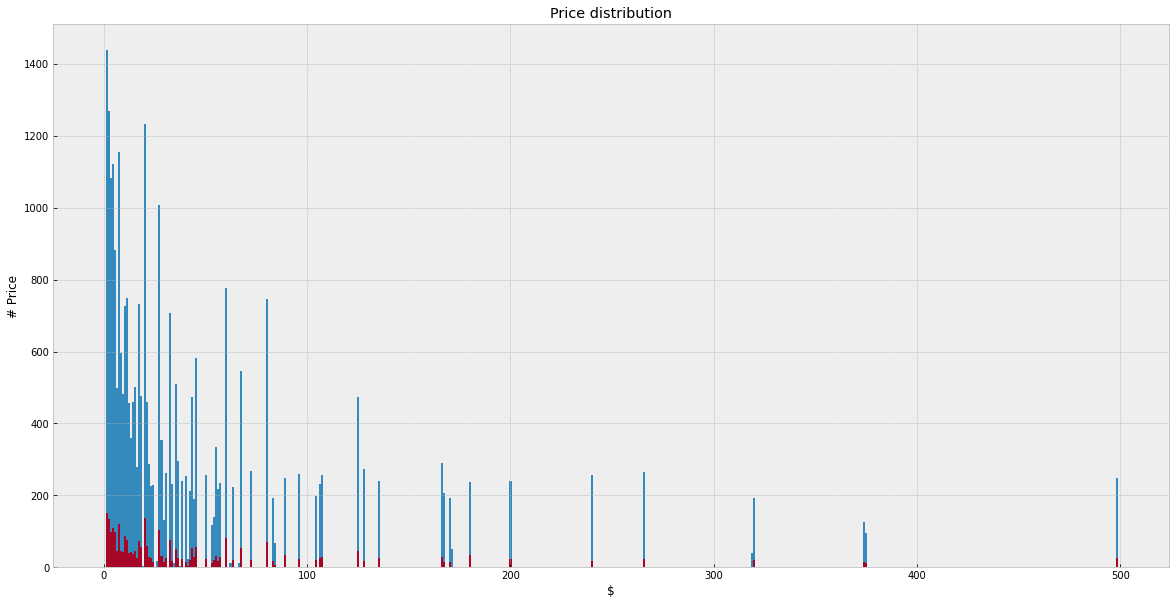

In [72]:
# Here is the histogram of the differences
plt.figure(figsize=(20,10))
plt.hist(y_train['cate_price'], bins=range_count)
plt.hist(y_val['cate_price'], bins=range_count)
plt.xlabel("$")
plt.ylabel("# Price")
_ = plt.title("Price distribution")

In [113]:
y_train['cate2_price'] = 0
print(y_train)
y_val['cate2_price'] = 0
print(y_val)


           price  cate_price  cate2_price
0      2404710.0         106            0
1       229480.0          10            0
2      1011780.0          45            0
3      2402870.0         106            0
4        55400.0           2            0
...          ...         ...          ...
29995  1417630.0          63            0
29996   342900.0          15            0
29997   129680.0           5            0
29998   190380.0           8            0
29999  1419630.0          63            0

[30000 rows x 3 columns]
          price  cate_price  cate2_price
0       85880.0           4            0
1     1006530.0          44            0
2     1254250.0          55            0
3      193380.0           8            0
4      967230.0          43            0
...         ...         ...          ...
2995   486530.0          21            0
2996   287570.0          12            0
2997   610380.0          27            0
2998   405860.0          18            0
2999  3846530.0    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [114]:
mt = y_train.groupby('cate_price').count()
k=0
km={}
for cp in mt.index:
  k += 1
  y_train.loc[y_train['cate_price']==cp, 'cate2_price'] = k
  km[cp] = k

for cp in mt.index:
  y_val.loc[y_val['cate_price']==cp, 'cate2_price'] = km[cp]

print(y_train)
print(y_val)


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


           price  cate_price  cate2_price
0      2404710.0         106           65
1       229480.0          10           11
2      1011780.0          45           44
3      2402870.0         106           65
4        55400.0           2            3
...          ...         ...          ...
29995  1417630.0          63           54
29996   342900.0          15           16
29997   129680.0           5            6
29998   190380.0           8            9
29999  1419630.0          63           54

[30000 rows x 3 columns]
          price  cate_price  cate2_price
0       85880.0           4            5
1     1006530.0          44           43
2     1254250.0          55           49
3      193380.0           8            9
4      967230.0          43           42
...         ...         ...          ...
2995   486530.0          21           22
2996   287570.0          12           13
2997   610380.0          27           27
2998   405860.0          18           19
2999  3846530.0    

In [116]:
from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train['cate2_price'])
y_val_one_hot = to_categorical(y_val['cate2_price'])

In [118]:
print(y_train_one_hot.shape)
print(y_val_one_hot.shape)


(30000, 85)
(3000, 85)


In [119]:
# Define the embedding input
cate_input = Input(shape=(2,), dtype='int32') 

# Decide to what vector size we want to map our 'area' variable. 
# I'll use 1 here because we only have three areas
embeddings_output = 24*3


# Let’s define the embedding layer and flatten it
cate_embedings = Embedding(output_dim=embeddings_output, input_dim=X_train_categorical.shape[0])(cate_input)
cate_embedings = keras.layers.Reshape((embeddings_output*2,))(cate_embedings)
print(cate_embedings)
# Define the continuous variables input (just like before)
continuous_input = Input(shape=(X_train_continuous.shape[1], ))

# Concatenate continuous and embeddings inputs
all_input = keras.layers.concatenate([continuous_input, cate_embedings])

Tensor("reshape_3/Reshape:0", shape=(None, 144), dtype=float32)


In [120]:
# Define the model
dense1 = Dense(y_train_one_hot.shape[1]*5, activation='relu')(all_input)
#dense2 = Dense(all_input.shape[1]*10, activation='relu')(dense1)
predictions = Dense(y_train_one_hot.shape[1],activation='softmax')(dense1)

# Note using the input object 'area_input' not 'area_embeddings'
model = Model(inputs=[continuous_input, cate_input], outputs=predictions)
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=.8, beta_1=0.9, beta_2=0.999, decay=1e-03, amsgrad=True),metrics=['accuracy'])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 2)            0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 2, 72)        2160000     input_5[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 3)            0                                            
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 144)          0           embedding_3[0][0]                
____________________________________________________________________________________________

In [121]:
epochs = 500

# Note continuous and categorical columns are inserted in the same order as defined in all_inputs
history = model.fit([X_train_continuous, X_train_categorical[['area_mapping','type_mapping']].to_numpy()], y_train_one_hot, 
          epochs=epochs, batch_size=128, 
          callbacks=[periodic_logger_250], verbose=0,
          validation_data=([X_val_continuous, X_val_categorical[['area_mapping','type_mapping']].to_numpy()], y_val_one_hot))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch: 250 - {'val_loss': 4.012602959950765, 'val_accuracy': 0.05066666752099991, 'loss': 4.036183134333292, 'accuracy': 0.0475}


KeyboardInterrupt: ignored